# Model Building<br/>*Hyperparameter Optimization*

## Goals
1. Optimize Hyperparameter for Regularization
2. Account for no final hold-out set
4. Create and analyze the Learning Curve
5. Compare new model to previous model

For an excellent alternative discussion of the topics present in this notebook, see: [Model Selection](https://towardsdatascience.com/a-short-introduction-to-model-selection-bb1bb9c73376)

## Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

import titanic_helper_code as tt

In [2]:
# Version Information
import sys
print('python:     ', sys.version)
print('numpy:      ', np.__version__)
print('pandas:     ', pd.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn:    ', sns.__version__)
print('sklearn:    ', sk.__version__)
!lsb_release -d

python:      3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy:       1.16.4
pandas:      0.24.2
matplotlib:  3.1.0
seaborn:     0.9.0
sklearn:     0.21.2
Description:	Ubuntu 18.04.2 LTS


## Recreate Model from Previous Iteration

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

In [4]:
# CV for model comparison, not model selection
cv_select = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, random_state=108)
cv_select_quick = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=108)

In [5]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

lr = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
pipe = Pipeline([('ct', ct), ('lr', lr)])

scores = cross_val_score(pipe, X, y, cv=cv_select, scoring='accuracy')
tt.print_scores(scores)

20 Scores  min:0.798 max:0.874
CV Mean Score: 0.834 +/- 0.017


The model from the previous iteration has been recreated.

## Preferred Method to<br/>Optimize Hyperparameters *And*<br/> Evaluate Performance of Optimized Model

Cross Validation cannot be used to *both* find the best hyperparameters *and* provide an accurate estimate of model performance.  In hyperparameter optimization, the CV test folds are used over and over again.  These test folds become data used as part of the model building process resulting in an overly optimistic estimate of model performance.

The preferred method to find the best model and estimate its performance on unseen data is:
* set aside a final hold-out test set to be used at the end of the project only
* use cross validation on the remaining data to:
  * to select the best hyperparameters
  * to experiment with the best features to extract
  * to experiment with the best data transformations
* having decided on the best way to build a model, build it on all the data except the final hold-out set
* evaluate this model on the final hold-out set

### Don't Use Final Hold-Out Set for Very Small Data Sets
The Titanic data set from Kaggle has 891 labeled records.

If 20% had been kept as a final hold-out set and 2-Fold CV had been used to select the best hyperparameters, then the CV process would be training on .8 * .5 * 891 = 356 records and evaluating on 356 records.  This is likely too few records to train on.  If 5-Fold CV is used, then there is more data for training, but less data for scoring, resulting in an inaccurate CV score causing less than the best hyperparameters to be chosen.  The Titanic data set is simply too small to make good use of a final hold-out set.

Depending on numerous factors, such as:
* the stability of the model being built  
* the amount of noise in the data  
* the number of features vs the number of records  
a final hold-out set may or may not be appropriate.

For small data sets, there are two other approaches that can be taken:
* the "one-standard-error" rule
* nested cross validation

Arguably nested cross validation is better, but the insights provided by the one-standard-error rule are very helpful.  As such, it will be presented first.

### One Standard Error Rule
The complexity of the model is reduced until a score 1 standard error below the optimal score is found.  This reduced complexity model is the model to deploy.

The rational is that simpler models tend to do better in practice.  This is often referred to as Occam's Razor or the principle of parsimony.  If the simpler model has a score within 1 standard deviation of the best model, then arguably its score is the same, so use the simpler model.

This is described in section 6.1 of [ISLR](http://www-bcf.usc.edu/~gareth/ISL/) or section 7.3 of [ESL](https://web.stanford.edu/~hastie/ElemStatLearn/).

As per [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) smaller values of C specify stronger regularization (i.e. reduced model complexity).

In the following, the error bars are placed at plus-or-minus 1/2 standard deviation from the mean.  Two scores will differ by 1 full standard deviation if the upper error bar of one just reaches the lower error bar of the other.

In [6]:
c_values = np.logspace(-2,1)
results = []
for c in c_values:
    
    lr = LogisticRegression(penalty='l2', C=c, solver='liblinear')
    pipe = Pipeline([('ct', ct), ('lr', lr)])

    scores = cross_val_score(pipe, X, y, cv=cv_select, 
                             scoring='accuracy')
    
    results.append((c, scores.mean(), 
                    scores.mean() - scores.std()/2,
                    scores.mean() + scores.std()/2,
                    scores.std()/2))

In [7]:
df = pd.DataFrame(data=results, columns=['C', 'Score', 'low', 'high', 'halfSD'])
df.head()

,C,Score,low,high,halfSD
0,0.010000,0.809870,0.803619,0.816120,0.006251
1,0.011514,0.811331,0.805168,0.817495,0.006164
2,0.013257,0.815374,0.809409,0.821339,0.005965
3,0.015264,0.817621,0.812001,0.823241,0.005620
4,0.017575,0.818296,0.812676,0.823917,0.005621


In [8]:
i_max = df['Score'].idxmax()
print('Best Score')
print(df.iloc[i_max])

Best Score
C         1.389495
Score     0.834914
low       0.826954
high      0.842875
halfSD    0.007961
Name: 35, dtype: float64


In [9]:
# low end of CI for highest Score
best_low = df.iloc[i_max]['low']

# decrease C (which increases regularization) to find the C
# for which the CIs overlap the least
for i in range(i_max, -1, -1):
    if df.loc[i]['high'] >= best_low:
        i_min = i
    else:
        break
print('Score: 1 SE Less')
print(df.loc[i_min])

midpoint = (df.loc[i_min]['high'] + df.loc[i_max]['low']) / 2

Score: 1 SE Less
C         0.023300
Score     0.822228
low       0.815965
high      0.828491
halfSD    0.006263
Name: 6, dtype: float64


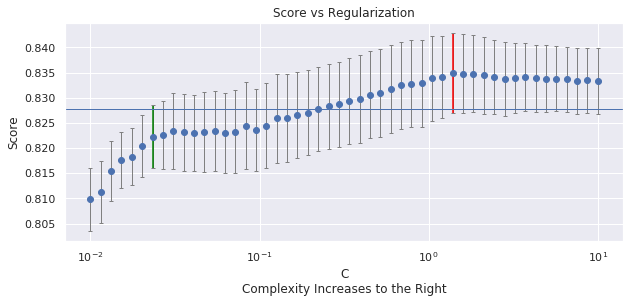

In [10]:
# plot the mean scores and their standard error vs C
fig = plt.figure(figsize=[10,4])

plt.errorbar(df['C'], df['Score'], yerr=df['halfSD'], 
             ecolor='gray', elinewidth=1, 
             fmt='o', capsize=2);
# Best
plt.errorbar(df['C'].iloc[i_max], df['Score'].iloc[i_max], 
             yerr=df['halfSD'].iloc[i_max], ecolor='red')
# 1 SE Less
plt.errorbar(df['C'].iloc[i_min], df['Score'].iloc[i_min], 
             yerr=df['halfSD'].iloc[i_min], ecolor='green')

ax = plt.gca()
ax.set_xscale('log')
plt.axhline(midpoint, linewidth=1)
plt.xlabel('C\nComplexity Increases to the Right')
plt.ylabel('Score');
plt.title('Score vs Regularization');

The optimal value of C was found, and then C was lowered until the confidence intervals just barely overlapped.  As the confidence intervals were +/- 1/2 SD, the difference between the means scores is 1 full SD.

The higher level of regularization results in a simpler model that is less likely to overfit the data.

Regularization reduces the degrees of freedom, which is similar to reducing the number of variables, except that it does so gradually.  L2 regularization is generally believed to allow for the best predictions.  L1 regularization can force a coefficient to zero, removing the variable entirely, which may allow for better interpretability.

The simpler model with a mean score of .822 seems worse than model with a mean score of .835, but as their confidence intervals overlap, they represent effectively the same score.

**Summary of One-Standard-Error**  
Without having a final hold-out set, there was no way to know if the hyperparameter optimized model overfit the data.  By backing off one-standard-error, with respect to tuning the hyperparameter for complexity, a simpler model was created with similar performance but less chance of overfit.

### Learning Curve
Before proceeding, it's a good idea to check the Learning Curve to see if the model is being trained well on the amount of data available to each cross validation train/test fold.

A Learning Curve will created for both the optimized model, and the model with increased regularization within 1 SD of the optimized model.

In [14]:
c_best = df.iloc[i_max]['C']
c_simple = df.iloc[i_min]['C']
c_best, c_simple

(1.3894954943731375, 0.023299518105153717)

In [15]:
# CV for Learning Curve
cv_lc = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=505)

In [16]:
# number of records to train on
# 5-Fold => (80% of 891) - 1 = 711
train_sizes = np.linspace(100, 711, 12).astype('int')
train_sizes

array([100, 155, 211, 266, 322, 377, 433, 488, 544, 599, 655, 711])

In [17]:
# Create a Learning Curve
from sklearn.model_selection import learning_curve

# plot both the best model, and the model one standard error simpler

lr_simple = LogisticRegression(penalty='l2', C=c_simple, solver='liblinear')
lr_best = LogisticRegression(penalty='l2', C=c_best, solver='liblinear')

pipe_simple = Pipeline([('ct', ct), ('lr_simple', lr_simple)])
pipe_best = Pipeline([('ct', ct), ('lr_best', lr_best)])

train1_sizes, train1_scores, test1_scores = \
    learning_curve(pipe_simple, X, y, train_sizes=train_sizes,
                   scoring="accuracy", cv=cv_lc)
train2_sizes, train2_scores, test2_scores = \
    learning_curve(pipe_best, X, y, train_sizes=train_sizes,
                   scoring="accuracy", cv=cv_lc)

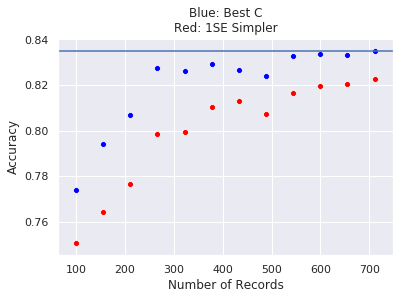

In [25]:
plt.xlabel('Number of Records')
plt.ylabel('Accuracy')
plt.title('Blue: Best C\nRed: 1SE Simpler')

best_score = df['Score'].iloc[i_max]
plt.axhline(best_score)

sns.scatterplot(x=train1_sizes, y=test1_scores.mean(axis=1), color='red');
sns.scatterplot(x=train2_sizes, y=test2_scores.mean(axis=1), color='blue');

The above shows that for all training set sizes, it is possible to distinguish between the two models.  This is because the learning bias (caused by training on too few records) is in the same direction for both models.  This is why low K works well for model selection.

Both models appear to be well trained by about the 600 record mark.

K vs Number of Train/Test Set Records (N=891)  
K=2  => 891 * 1/2  = 450 train, 450 test  
K=3  => 891 * 2/3  = 594 train, 297 test  
K=4  => 891 * 3/4  = 668 train, 223 test  
K=5  => 891 * 4/5  = 712 train, 179 test  
K=10 => 891 * 9/10 = 801 train, 90 test   

At K=3, about 600 records are used for training.  So at K=3 the bias due to training on too few records is small.

At K=3, about 300 records are used for computing the score, whereas at K=10 about 90 records are used for computing the score.  The variance of the score will be lower when computed on 300 records vs being computed on 90 records.  This means that K=3 will be better able to distinguish which of 2 models is best, than K=10.

Although there is more training bias at K=2 than at K=3, the models are well distinguished from one another at K=2.  So K=2 Folds also works well for the purpose of determining which model is best.

### Nested Cross Validation Description
Nested Cross Validation requires significantly more computation time than regular CV, but it is only needed when there is a small amount of data.

Nested Cross Validation works by embedding GridSearchCV inside of cross_val_score.  This puts the entire model building process inside of cross validation, ensuring that the entire model building process is being properly evaluated.

Often K=2 is chosen for the inner CV (which performs model selection) and K=5 is chosen for the outer CV (which performs model evaluation).

#### Nested CV Code Preparation

In [ ]:
# First: Verify that non-nested GridSearchCV gives same result as above

# Parameters to optimize over
p_grid = {"lr__C": np.logspace(-2,1)}

lr = LogisticRegression(penalty='l2', C=c, solver='liblinear')
pipe = Pipeline([('ct', ct), ('lr', lr)])

grid = GridSearchCV(estimator=pipe, param_grid=p_grid, 
                    scoring='accuracy', cv=cv_select)

# find the best hyperparameters and associated score
grid.fit(X, y);

In [ ]:
# Copied from titanic_helper_code.py
def print_grid(grid, pandas=False):
    '''Print and Return GridSearchCV Results'''
          
    std = grid.cv_results_['std_test_score'][grid.best_index_]
    print(f'Best: {grid.best_score_:0.3f} +/- {std/2:0.3f}')
    for key, value in grid.best_params_.items():
        print(f'{key}: {value}')
        

    if pandas:
        results=[]
        for i in range(len(grid.cv_results_['mean_test_score'])):
            score  = grid.cv_results_['mean_test_score'][i]
            std    = grid.cv_results_['std_test_score'][i]
            params = grid.cv_results_['params'][i]
            params['score'] = score
            params['std'] = std
            results.append(params)
        
        return pd.DataFrame(results)

In [ ]:
# verify these are the sames scores as computed with the for-loop
df2 = tt.print_grid(grid, pandas=True)
print(f'Same Scores: {np.isclose(df2["score"], df["Score"], rtol=1e-4).all()}')

This are the same values as for the above for-loop.

#### Nested CV Code
Now encapsulate GridSearchCV itself inside of cross validation.  This ensures that the model building process is fully within cross validation.

Note this works because by default refit=True.  This means the model used for prediction inside of cross validation is the model fitted with the best parameters found on that test fold.

In [ ]:
cv_eval = RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=1001)

p_grid = {"lr__C": np.logspace(-2,1)}
lr = LogisticRegression(penalty='l2', C=c, solver='liblinear')
pipe = Pipeline([('ct', ct), ('lr', lr)])

grid = GridSearchCV(estimator=pipe, param_grid=p_grid, 
                    scoring='accuracy', cv=cv_select_quick)

scores = cross_val_score(grid, X, y, scoring='accuracy', cv=cv_eval)
tt.print_scores(scores)

In [ ]:
tt.print_scores(scores)

The Nested CV estimate of model performance is: 0.830 +/- 0.012.

This is virtually the same as the 10x 2-Fold CV estimate of 0.834 +/- 0.008 for the model with the best value for C.

In most cases, it would be expected that nested CV produces a lower estimate (by removing the upward bias) and a larger margin of error than using the result from GridSearchCV or similar.

Here it looks like using the best value found for C should generalize well.

In [ ]:
# Read scores from 4th iteration
prev_scores = np.load('./data/iter04.data.npy')
print(f'Previous CV Mean Score: {prev_scores.mean():.3f} +/- {prev_scores.std()/2:.3f}')

The previous iteration's score is effectively the same as the nested CV score for the hyperparameter optimized model.  As such, optimizing C did not improve the model.

### Notebook Summary

* hyperparameter for regularization was optimized
* one-standard-error rule was used to find a simpler model
  * sometimes it's better to deploy a simpler model, it depends on the application
* learning curve showed there was sufficient data to perform nested CV
* nested CV's estimate of model performance, for this model, was essentially the same as the non-optimized model

The Titanic data set is rather simple and small.  This is about as much as can be done with it using LogisitcRegression.

In the next notebook, different estimators will be tried, and they will be combined with Stacking to see if a better result is possible.